<a href="https://colab.research.google.com/github/ACTP2002/EVIDENCE/blob/behavior_model/behavior_model_isolation_forest_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --no-cache-dir -U numpy pandas scipy scikit-learn tensorflow shap matplotlib joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 146.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 146.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 142.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 149.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 152.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 181.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      S

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import random

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import shap
import joblib


In [ ]:
data_path = "synthetic_data_2026-02-07.csv"

df = pd.read_csv(data_path)
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_123,2025-04-29T00:41:35,deposit,4340.76,GBP,api,103233,201910,AU,AU,7383.39,7514.33,0,0,False,False
1,u_066,2025-12-12T02:40:46,withdrawal,7644.75,JPY,mobile,147944,491914,BR,BR,5619.80,13616.50,0,0,True,False
2,u_323,2025-03-03T11:31:43,sell,6430.32,USD,mobile,89130,57834,CN,CN,13932.37,3767.63,4,0,False,False
3,u_279,2025-11-24T00:26:14,buy,303.06,EUR,api,26802,421080,CN,CN,3947.08,1865.10,2,0,True,False
4,u_380,2025-04-22T23:01:29,buy,1164.22,EUR,api,25900,280156,MY,MY,1918.26,1456.34,0,0,False,False


In [ ]:
# convert time to proper format
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
# sort by user id and event time
df = df.sort_values(["user_id", "event_time"]).reset_index(drop=True)

# Normalize categorical text to ensure all lower text
cat_cols_raw = [
    "currency", "channel",
    "residence_country", "transaction_country",
    "event_type"
]

for c in cat_cols_raw:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

In [ ]:
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_000,2025-01-06 11:18:48,deposit,10254.28,gbp,mobile,102892,82668,vn,vn,12593.03,11280.03,0,0,False,False
1,u_000,2025-02-03 17:39:16,withdrawal,3584.68,usd,web,102892,82668,vn,vn,11413.28,7055.52,3,1,True,False
2,u_000,2025-02-14 13:10:20,deposit,7219.40,gbp,api,102892,82668,vn,vn,14621.12,8020.41,3,2,True,False
3,u_000,2025-02-15 17:08:36,withdrawal,9331.13,gbp,api,102892,82668,vn,vn,9792.10,9161.38,0,0,True,False
4,u_000,2025-02-18 00:55:12,deposit,5060.26,usd,mobile,102892,82668,vn,vn,15287.90,9269.69,1,2,False,False


Feature Engineering Process




1.   Rolling behaviour for each user. Purpose: To compare the behaviour within the n
window

User transaction rate:


*   More than 7 transactions => USER MEDIAN + USER MAD
*   Between 2 to 6 transactions => USER MEDIAN + GLOBAL MAD
*   1 Transaction => COHORT MEDIAN + MAD

2.   Transaction timing
3.   Financial Patterns
4.   Location Abnormality

In [ ]:
# Transaction Amount Features

df["amount_abs"] = df["amount"].abs()

df["amount_to_income_ratio"] = (df["amount_abs"] / (df["declared_income"] + 1e-9))

df["deposit_to_income_ratio"] = (df["account_deposit"] / (df["declared_income"] + 1e-9))

# Net flow per day
df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

# Transaction Gap features

grp = df.groupby("user_id", sort=False)

# Previous timestamp per group
df["prev_event_time"] = grp["event_time"].shift(1)

# Gap between consecutive transactions (in seconds)
df["gap_seconds"] = (df["event_time"] - df["prev_event_time"]).dt.total_seconds()

# Fill first-transaction gaps
df["gap_seconds"] = df["gap_seconds"].fillna(df["gap_seconds"].median())

# Log-scaled time gap
df["gap_log"] = np.log1p(df["gap_seconds"])


# Inconsistent Location

df["is_cross_border"] = (df["residence_country"] != df["transaction_country"]).astype(int)


# Access risk
df["failed_login_ratio_1h"] = (df["failed_login_1h"] / (df["login_count_1h"] + 1e-9))

df["new_ip_1d"] = df["new_ip_1d"].fillna(0)

df["geo_change_1d"] = df["geo_change_1d"].fillna(0)



In [ ]:
# 1 TRANSACTION ONLY

EPS = 1e-9

# GLOBAL MEDIAN & MAD
GLOBAL_MEDIAN = df["amount_abs"].median()
GLOBAL_MAD = median_abs_deviation(df["amount_abs"], scale="normal") + EPS

# COHORT MEDIAN + MAD
cohort_cols = ["currency", "transaction_country", "channel", "event_type"]
cohort_stats = (df.groupby(cohort_cols)["amount_abs"].agg(["median", lambda x: median_abs_deviation(x, scale="normal")]).reset_index())
cohort_stats.columns = cohort_cols + ["cohort_median", "cohort_mad"]
cohort_stats["cohort_mad"] += 1e-9

df = df.merge(cohort_stats, on=cohort_cols, how="left")

In [ ]:
ROLL_WINDOW = 15
ROLL_MIN = 2 # minimum transactions for rolling window else treated as single transaction

# Rolling windows (15 transactions minimum, 2 transactions at least to compute)
df["user_median_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).median())

# Rolling MAD
df["user_mad_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).apply(lambda x: median_abs_deviation(x, scale="normal"), raw=False))

# Fallback logic [User level => Cohort level => Global level]
df["baseline_median"] = df["user_median_15"].fillna(df["cohort_median"]).fillna(GLOBAL_MEDIAN)
df["baseline_mad"] = df["user_mad_15"].fillna(df["cohort_mad"]).fillna(GLOBAL_MAD)

# Modified z-score
df["mod_z_score"] = 0.6745 * (df["amount_abs"] - df["baseline_median"]) / (df["baseline_mad"] + EPS)
df["mod_z_score_abs"] = df["mod_z_score"].abs()

In [ ]:
### EWMA (Exponentially Weighted Moving Average)
df["ewma"] = grp["amount_abs"].transform(lambda s: s.ewm(span=8, adjust=False).mean())

df["ewma_resid"] = (df["amount_abs"] - df["ewma"]).abs()


In [ ]:
# Global chronological split (80,20)
cutoff = df["event_time"].quantile(0.8)

train_df = df[df["event_time"] <= cutoff].copy()
test_df = df[df["event_time"] > cutoff].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (16000, 35) Test: (4000, 35)


Isolation Forest Model

Features: Transaction amount, Modified z-score (transaction changes), EWMA (drift), Transaction timing gap, Amount to income ratio and inconsistent location

Role: Globally detect any anomalous events

In [ ]:
isolation_forest_features = [
    "amount_abs",
    "mod_z_score_abs",
    "ewma_resid",
    "gap_log",
    "deposit_to_income_ratio",
    "amount_to_income_ratio",
    "amount_in_1d",
    "amount_out_1d",
    "net_flow_1d",
    "login_count_1h",
    "failed_login_ratio_1h",
    "new_ip_1d",
    "geo_change_1d",
    "is_cross_border"
]
# isolation_forest_features = ["amount_abs", "mod_z_score_abs", "ewma_resid", "gap_log", "amount_to_income_ratio", "is_cross_border"]

# cat_features = [
#     "currency",
#     "channel",
#     "event_type",
#     "transaction_country"
# ]

# isolation_forest_features = [c for c in isolation_forest_features if c in df.columns]
# num_features = [c for c in num_features if c in df.columns]
# cat_features = [c for c in cat_features if c in df.columns]

In [ ]:
num_imputer = SimpleImputer(strategy="median")
num_scaler = RobustScaler()

X_train_isolation_forest = num_scaler.fit_transform(num_imputer.fit_transform(train_df[isolation_forest_features]))

X_test_isolation_forest = num_scaler.transform(num_imputer.fit_transform(test_df[isolation_forest_features]))

isoForest_model = IsolationForest(
    n_estimators=600,
    max_samples="auto",
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

isoForest_model.fit(X_train_isolation_forest)

test_df["iforest_score"] = -isoForest_model.decision_function(X_test_isolation_forest)

In [ ]:
print(test_df["iforest_score"])

53       0.054404
54       0.054416
55       0.000719
56       0.008570
57      -0.053276
           ...   
19995   -0.129290
19996   -0.030119
19997   -0.132302
19998   -0.101331
19999   -0.080399
Name: iforest_score, Length: 4000, dtype: float64


In [ ]:
lstm_autoencoder_features = ["amount_abs", "gap_log", "amount_to_income_ratio", "mod_z_score_abs", "ewma_resid", "is_cross_border"]

seq_scaler = StandardScaler()
seq_scaler.fit(train_df[lstm_autoencoder_features].fillna(0))

def make_sequences(data_in, window=20):
  X = []
  idx = []
  for _, g in data_in.groupby("user_id", sort=False):
    arr = seq_scaler.transform(g[lstm_autoencoder_features].fillna(0))
    if len(arr) < window:
      continue
    for i in range (window - 1, len(arr)):
      X.append(arr[i-window+1:i+1])
      idx.append(g.index[i])
  return np.array(X), idx


X_training_lstm, idx_training_lstm = make_sequences (train_df)
X_testing_lstm, idx_testing_lstm = make_sequences (test_df)

In [ ]:
lstm_model = models.Sequential([
    layers.Input(shape=(20, len(lstm_autoencoder_features))),
    layers.LSTM(64),
    layers.RepeatVector(20),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(len(lstm_autoencoder_features)))
])

lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.fit(
    X_training_lstm, X_training_lstm,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=2
)

Epoch 1/40
30/30 - 8s - 280ms/step - loss: 0.9983 - val_loss: 0.8198
Epoch 2/40
30/30 - 4s - 121ms/step - loss: 0.9679 - val_loss: 0.7906
Epoch 3/40
30/30 - 3s - 104ms/step - loss: 0.9184 - val_loss: 0.7245
Epoch 4/40
30/30 - 4s - 129ms/step - loss: 0.8603 - val_loss: 0.6788
Epoch 5/40
30/30 - 4s - 146ms/step - loss: 0.8092 - val_loss: 0.6270
Epoch 6/40
30/30 - 3s - 105ms/step - loss: 0.7611 - val_loss: 0.5879
Epoch 7/40
30/30 - 5s - 171ms/step - loss: 0.7209 - val_loss: 0.5590
Epoch 8/40
30/30 - 6s - 200ms/step - loss: 0.6822 - val_loss: 0.5317
Epoch 9/40
30/30 - 7s - 245ms/step - loss: 0.6720 - val_loss: 0.5481
Epoch 10/40
30/30 - 4s - 148ms/step - loss: 0.6356 - val_loss: 0.4615
Epoch 11/40
30/30 - 3s - 104ms/step - loss: 0.5955 - val_loss: 0.4589
Epoch 12/40
30/30 - 5s - 169ms/step - loss: 0.5673 - val_loss: 0.4178
Epoch 13/40
30/30 - 4s - 149ms/step - loss: 0.5309 - val_loss: 0.4154
Epoch 14/40
30/30 - 3s - 104ms/step - loss: 0.5552 - val_loss: 0.5654
Epoch 15/40
30/30 - 3s - 105m

In [ ]:
y_pred_lstm = lstm_model.predict(X_testing_lstm, verbose=0)
err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=(1, 2))

test_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_testing_lstm):
  test_df.at[idx, "lstm_score"] = err[i]

test_df["lstm_score"] = test_df["lstm_score"].fillna(test_df["lstm_score"].median())

In [ ]:
print(test_df["lstm_score"])

53       0.140668
54       0.140668
55       0.140668
56       0.140668
57       0.140668
           ...   
19995    0.140668
19996    0.140668
19997    0.140668
19998    0.140668
19999    0.140668
Name: lstm_score, Length: 4000, dtype: float64


In [ ]:
detector_cols = ["mod_z_score_abs", "ewma_resid", "iforest_score", "lstm_score"]

train_df["iforest_score"] = -isoForest_model.decision_function(X_train_isolation_forest)

y_pred_training_lstm = lstm_model.predict(X_training_lstm, verbose=0)
train_err = np.mean((X_training_lstm - y_pred_training_lstm) ** 2, axis=(1, 2))

train_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_training_lstm):
  train_df.at[idx, "lstm_score"] = train_err[i]

train_df["lstm_score"] = train_df["lstm_score"].fillna(train_df["lstm_score"].median())


scaler = MinMaxScaler()
scaler.fit(train_df[detector_cols].fillna(0))

test_df[[c + "_n" for c in detector_cols]] = scaler.transform(test_df[detector_cols].fillna(0))

weights = {
    "mod_z_score_abs": 0.3,
    "ewma_resid": 0.15,
    "iforest_score": 0.3,
    "lstm_score": 0.25
}

test_df["final_score"] = sum(weights[c] * test_df[c+"_n"] for c in weights)

In [ ]:
threshold = test_df["final_score"].quantile(0.95)
test_df["is_anomaly"] = (test_df["final_score"] >= threshold).astype(int)

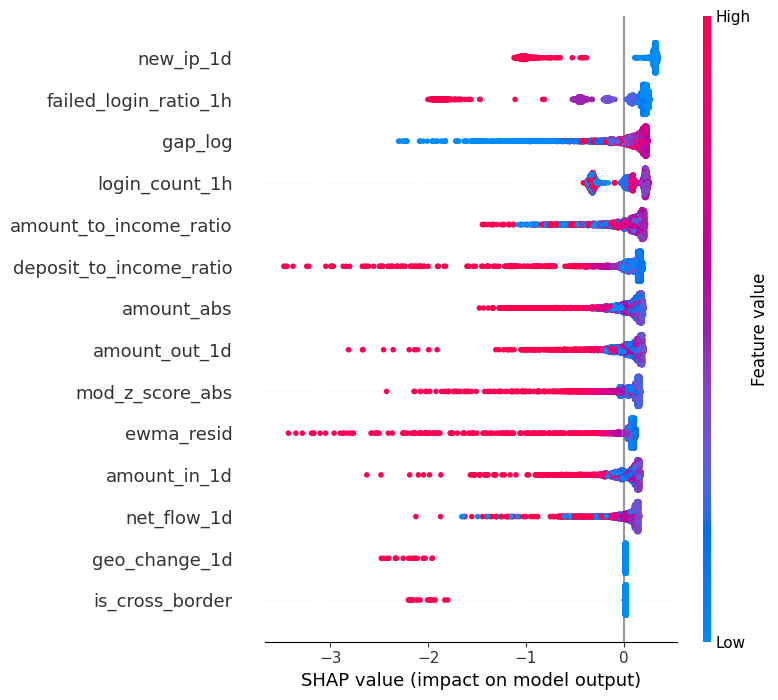

In [ ]:
explainer = shap.TreeExplainer(isoForest_model)
shap_values = explainer.shap_values(pd.DataFrame(X_test_isolation_forest, columns=isolation_forest_features))

shap.summary_plot(shap_values, pd.DataFrame(X_test_isolation_forest, columns=isolation_forest_features))

In [ ]:
feature_err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=1)
feat_err_df = pd.DataFrame(feature_err, columns=lstm_autoencoder_features, index=idx_testing_lstm)

test_df["lstm_top_driver"] = feat_err_df.idxmax(axis=1)

In [ ]:
print(test_df.head())

   user_id          event_time  event_type   amount currency channel  \
53   u_000 2025-10-22 16:18:50         buy  7943.74      gbp     api   
54   u_000 2025-10-22 23:57:53  withdrawal  4517.57      eur     web   
55   u_000 2025-10-24 15:08:38  withdrawal  5744.46      gbp  mobile   
56   u_000 2025-11-17 13:29:11        sell  5234.14      jpy     api   
57   u_000 2025-11-21 11:46:47         buy  6169.14      eur  mobile   

    declared_income  account_deposit residence_country transaction_country  \
53           102892            82668                vn                  vn   
54           102892            82668                vn                  vn   
55           102892            82668                vn                  vn   
56           102892            82668                vn                  vn   
57           102892            82668                vn                  vn   

    ...    ewma_resid  iforest_score  lstm_score  mod_z_score_abs_n  \
53  ...  31470.322698      

Preprocessing Features
Isolation Forest handles numeric data only. We have both numeric and categorical data.

1. Column Transformer to apply preprocessing to each column type and **give one final numeric feature matric**

2. Numeric Pipeline


*   Simple Imputer - Fill missing values with median
*   Robust Scaler - scale features using median and IQR. Not standard scaler which is sensitive to outliers

3. Categorical Pipeline


*   Simple Imputer - Fill missing values with mode
*   One Hot Encoder - new categories are ignored and categories that appear less than 10 times grouped under one bucket (avoid rare categories as anomaly)

Other columns are dropped





In [ ]:
# preprocess = ColumnTransformer(
#     transformers=[
#         (
#             "num",
#             Pipeline(
#                 steps=[
#                     ("imputer", SimpleImputer(strategy="median")),
#                     ("scaler", RobustScaler())
#                 ]
#             ),
#             num_features
#         ),
#         (
#             "cat",
#             Pipeline(
#                 steps=[
#                     ("imputer", SimpleImputer(strategy="most_frequent")),
#                     ("oh", OneHotEncoder(
#                         handle_unknown="ignore",
#                         min_frequency=10
#                     ))
#                 ]
#             ),
#             cat_features
#         ),
#     ],
#     remainder="drop"
# )

In [ ]:
isoForest_model = IsolationForest(
    n_estimators=600,
    max_samples="auto",
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

iso_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", isoForest_model)
    ]
)

iso_pipe.fit(train_df)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [ ]:
# Scoring
test_df["iforest_score_raw"] = iso_pipe.decision_function(test_df)
test_df["anomaly_score"] = -test_df["iforest_score_raw"]

# Threshold
threshold = test_df["anomaly_score"].quantile(0.95)
test_df["is_anomaly_pred"] = (
    test_df["anomaly_score"] >= threshold
).astype(int)

In [ ]:
cols_to_view = [
    "user_id", "event_time", "event_type",
    "amount", "declared_income",
    "failed_login_1h", "login_count_1h",
    "new_ip_1d", "geo_change_1d",
    "residence_country", "transaction_country",
    "anomaly_score"
]
cols_to_view = [c for c in cols_to_view if c in test_df.columns]

print(
    test_df.sort_values("anomaly_score", ascending=False)[cols_to_view].head(20)
)


      user_id          event_time event_type     amount  declared_income  \
3349    u_067 2025-12-21 16:42:34    deposit  375798.08           137371   
9312    u_186 2025-10-30 21:49:41    deposit  425676.11           114773   
4477    u_090 2025-11-23 08:26:06    deposit  348662.82           118214   
16796   u_335 2025-12-16 10:41:20    deposit  366201.98           124662   
11650   u_232 2025-11-23 09:06:51    deposit  276509.68            67236   
15466   u_309 2025-12-21 00:24:54    deposit  428657.31           133177   
1510    u_029 2025-11-23 03:29:10    deposit  637127.11           140541   
19263   u_385 2025-11-15 02:30:57    deposit  298680.74            73080   
7665    u_154 2025-11-30 05:46:23    deposit  229644.71           111300   
7573    u_152 2025-12-13 20:17:36    deposit  297667.92            85727   
19120   u_382 2025-12-19 15:49:55    deposit  236344.19            59206   
4474    u_090 2025-11-17 14:53:58    deposit  230572.92           118214   
9625    u_19

In [ ]:
user_anom = (
    test_df.groupby("user_id")["is_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 users by anomaly count:")
print(user_anom.head(10))


Top 10 users by anomaly count:
user_id
u_029    8
u_090    8
u_079    6
u_344    6
u_186    6
u_179    5
u_067    4
u_341    4
u_190    4
u_170    4
Name: is_anomaly, dtype: int64


In [ ]:
n_users = user_anom.shape[0]
top_k = max(1, int(0.05 * n_users))

share_top5 = user_anom.head(top_k).sum() / (user_anom.sum() + 1e-9)

print(f"Top 5% users contribute: {share_top5:.2%} of all anomalies")


Top 5% users contribute: 39.50% of all anomalies


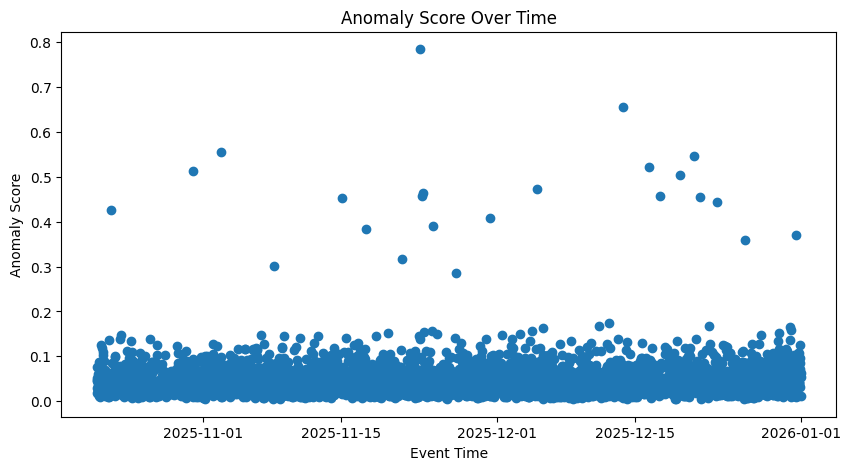

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(
    test_df["event_time"],
    test_df["final_score"]
)
plt.xlabel("Event Time")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Over Time")
plt.show()
